In [41]:
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import torchvision
import json

class GunDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, train=True):
      with open(annotation_dir, "r") as f:
        coco_data = json.load(f)
      self.image_dir = image_dir
      self.transform = transform
      self.train = train
      self.images = coco_data['images']
      self.annotations = coco_data['annotations']
      self.categories = {}
      self.id_to_name = {}
      
      for category in coco_data['categories']:
          new_id = len(self.categories) + 1
          self.categories[category['id']] = new_id
          self.id_to_name[new_id] = category['name']
      
      print("Categorie trovate:")
      for new_id, name in self.id_to_name.items():
          print(f"- {name}: {new_id}")
      
      # Crea il mapping immagine -> annotazioni (solo per armi)
      self.img_to_anns = {img['id']: [] for img in self.images}
      for ann in self.annotations:
          self.img_to_anns[ann['image_id']].append(ann)
      
      self.images = [img for img in self.images if len(self.img_to_anns[img['id']]) > 0]
      
      print(f"Immagini totali con armi: {len(self.images)}")
      print(f"Annotazioni di armi totali: {len(self.annotations)}")
      
    def __len__(self):
        return len(self.images)
      
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, str(self.images[idx]['file_name']))
        image = Image.open(image_path).convert("RGB")
        
        img_id = self.images[idx]['id']
        annotations = self.img_to_anns[img_id]
        
        # Conversione annotazioni COCO in Pascal VOC
        boxes = []
        labels = []  
        for ann in annotations:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(self.categories[ann['category_id']])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, boxes, labels

In [42]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_dataset_folder = "../Dataset/fasterrcnn/train"

transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_dataset = GunDataset(train_dataset_folder, train_dataset_folder+"/_annotations.coco.json", transform=transform)

Categorie trovate:
- Weapons: 1
- Handgun: 2
- Rifle: 3
Immagini totali con armi: 12489
Annotazioni di armi totali: 15919


In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=len(train_dataset.categories) + 1)

model_path = '../Models/best_model_fasterrcnn_base.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [44]:
import torchvision

def apply_nms(boxes, scores, iou_threshold=0.5):
    keep_indices = torchvision.ops.nms(boxes, scores, iou_threshold)
    return keep_indices.cpu().numpy()

In [45]:
import torchvision.transforms as T
from PIL import Image, ImageDraw

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    image_tensor = transform(image)
    return image, image_tensor

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageDraw, ImageFont

def visualize_prediction(image, boxes, scores, labels, threshold=0.5, id_to_name=None):
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)
    
    try:
        font = ImageFont.truetype('arial.ttf', 20)
    except IOError:
        font = ImageFont.load_default()
    
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    
    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            filtered_boxes.append(box)
            filtered_scores.append(score)
            filtered_labels.append(label)
    
    for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
        x1, y1, x2, y2 = box
        
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
        
        class_name = id_to_name[label]
        label_text = f"{class_name}: {score:.2f}"
        draw.text((x1, y1-25), label_text, fill="red", font=font)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(np.array(draw_image))
    plt.axis('off')
    plt.show()
    
    return draw_image

In [47]:
def detect_guns(image_path, confidence_threshold=0.5, id_to_name=train_dataset.id_to_name):
    original_image, image_tensor = load_image(image_path)
    
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])
    
    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    
    keep_indices = apply_nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold=0.2)
    
    boxes = boxes[keep_indices]
    scores = scores[keep_indices]
    labels = labels[keep_indices]
    
    result_image = visualize_prediction(original_image, boxes, scores, labels, 
                                      confidence_threshold, id_to_name)
    
    return {
        'boxes': boxes,
        'scores': scores,
        'labels': labels,
        'result_image': result_image
    }

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (1).jpg


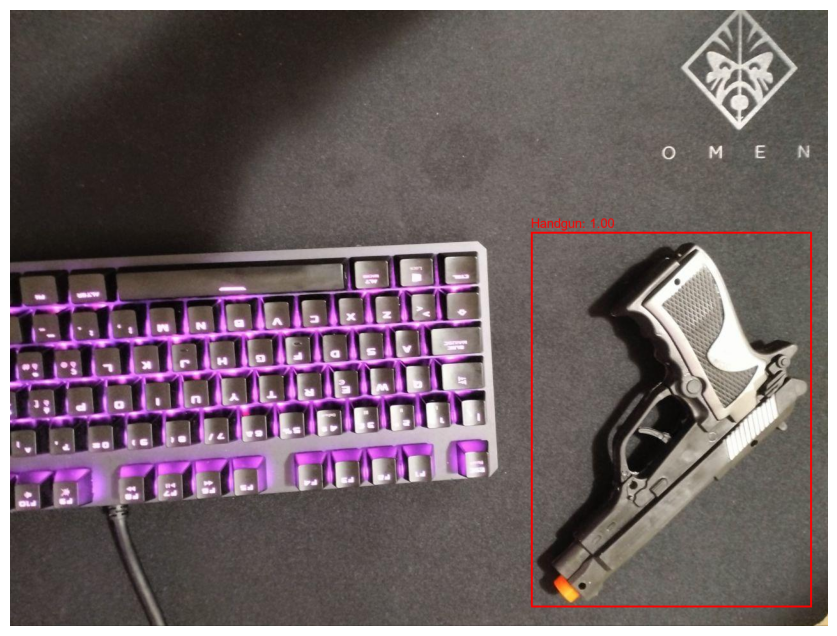

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (10).jpg


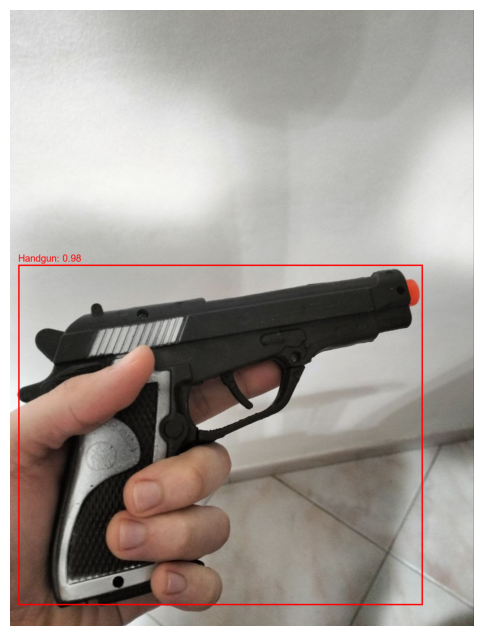

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (11).jpg


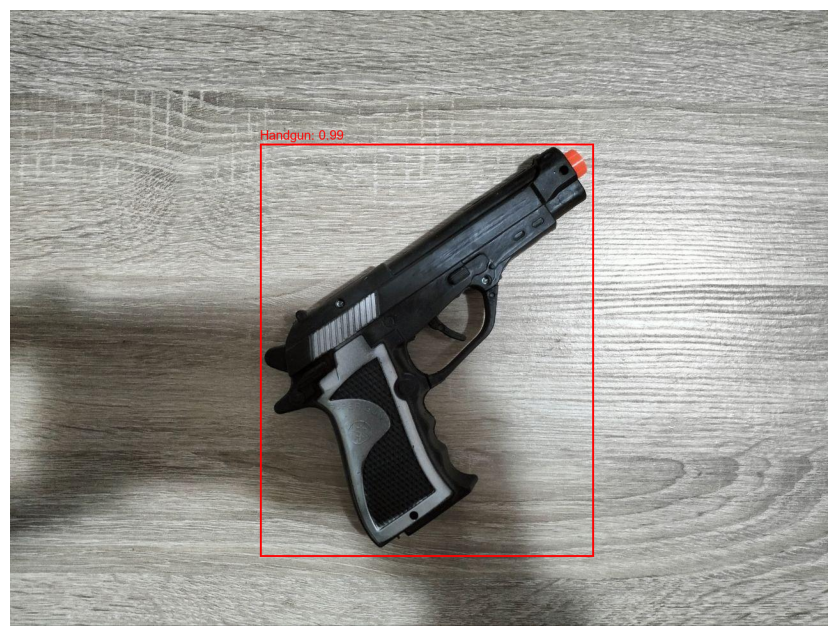

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (12).jpg


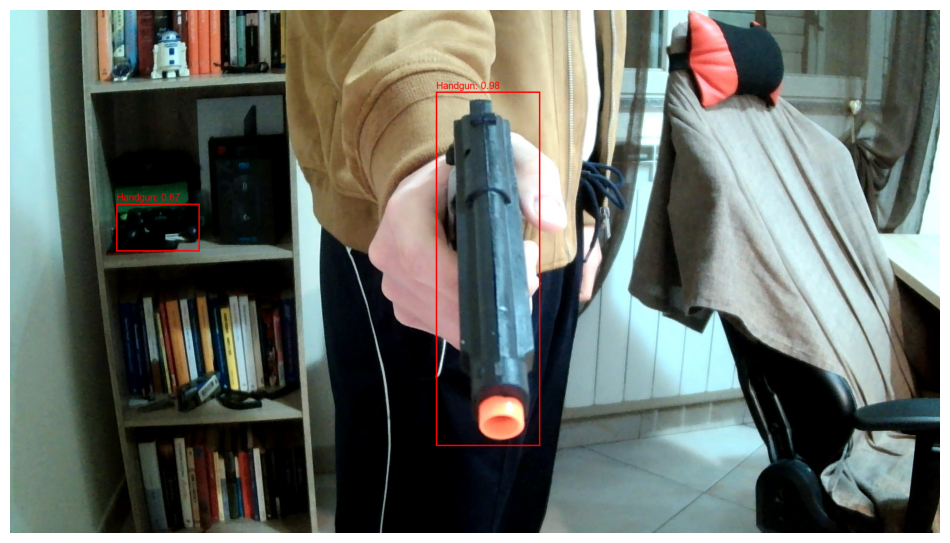

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (13).jpg


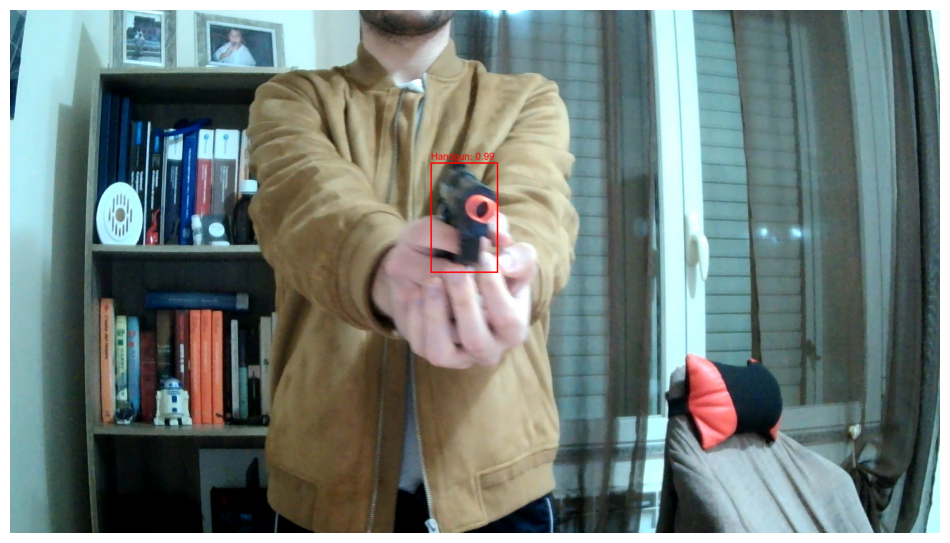

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (14).jpg


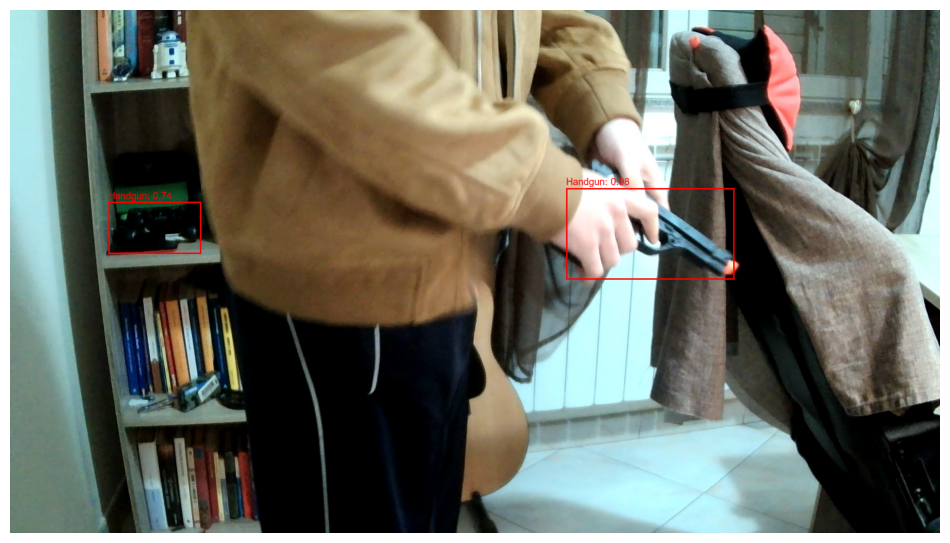

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (15).jpg


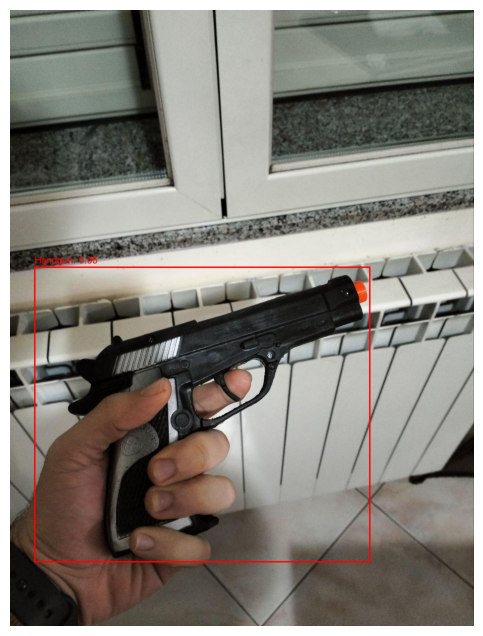

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (2).jpg


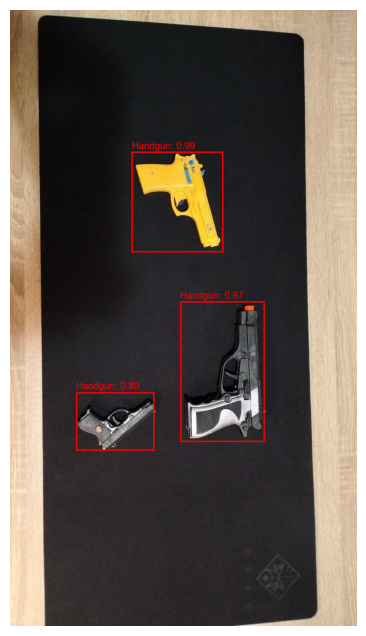

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (3).jpg


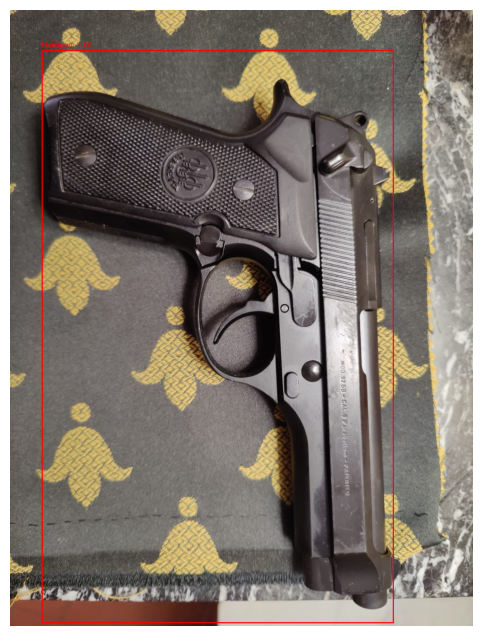

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (4).jpg


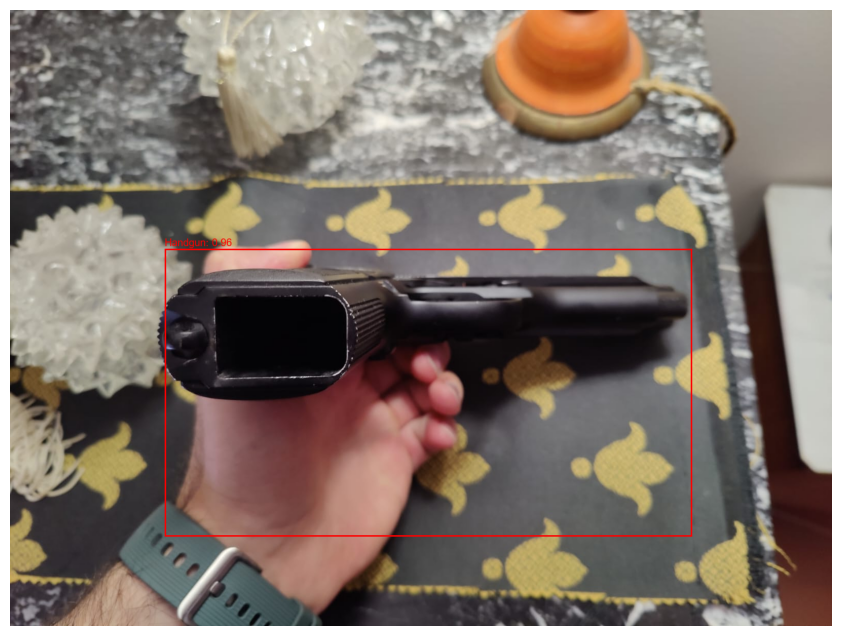

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (5).jpg


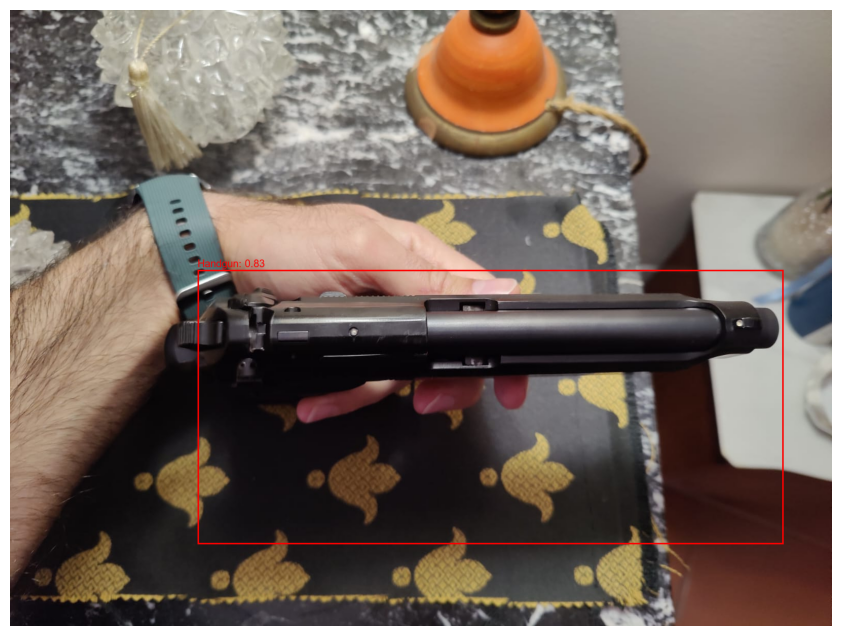

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (6).jpg


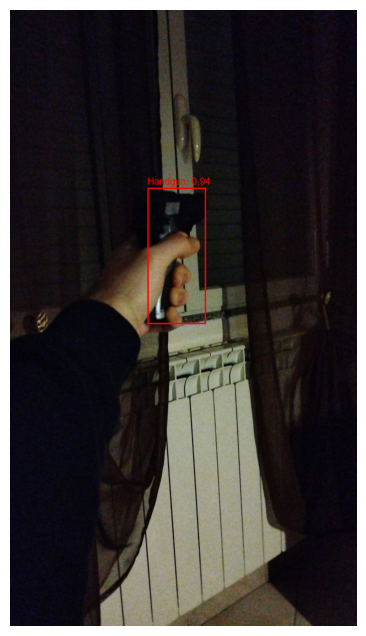

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (7).jpg


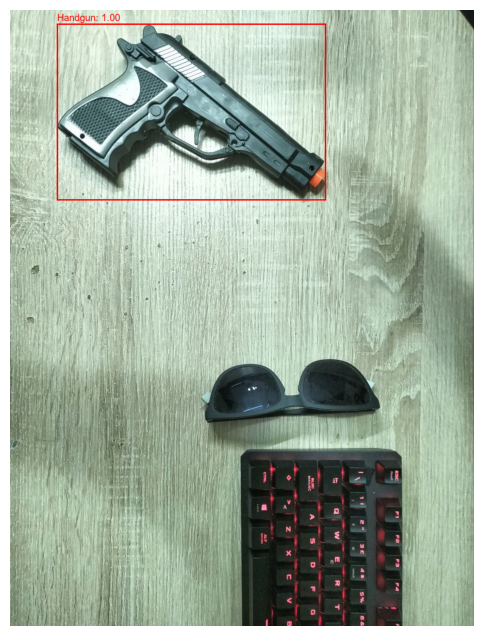

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (8).jpg


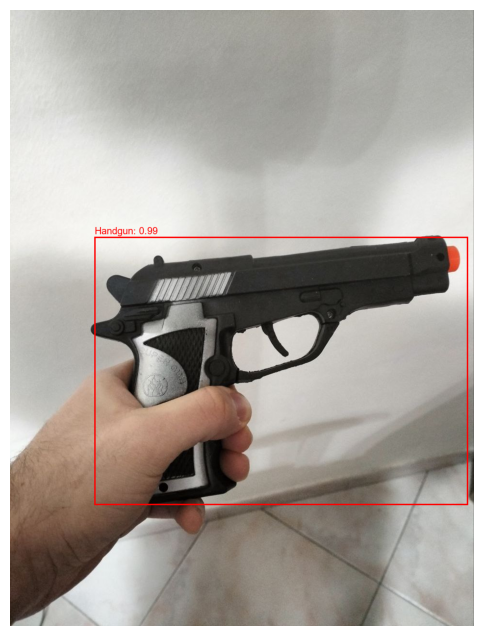

Esecuzione rilevamento armi su: ../Dataset/fasterrcnn/test/test (9).jpg


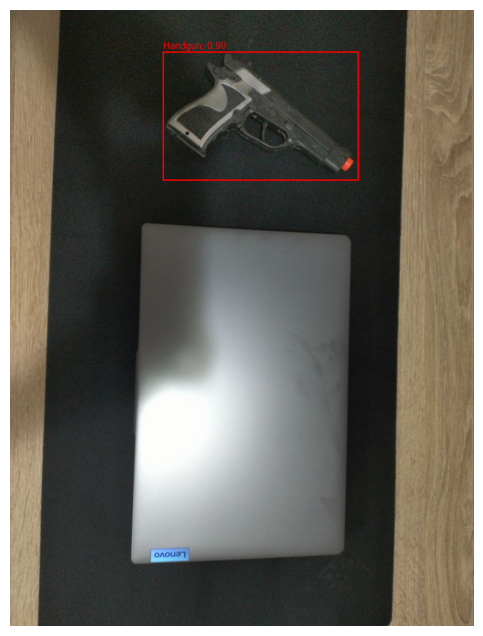

Armi rilevate: 19


In [48]:
if __name__ == "__main__":
    test_images = os.listdir("../Dataset/fasterrcnn/test")
    test_images = [os.path.join("../Dataset/fasterrcnn/test/", image) for image in test_images]
    guns_detected = 0
    
    for image_path in test_images:
        print(f"Esecuzione rilevamento armi su: {image_path}")
        results = detect_guns(image_path, confidence_threshold=0.6)
        guns_detected += sum(1 for score in results['scores'] if score >= 0.6)
        
    print(f"Armi rilevate: {guns_detected}")